# Deep ROC analysis tool introduction
---
## for your own results, or with examples
### Code by André Carrington, Franz Mayr, Yusuf Sheikh  
    
This tool analyzes data in ROC plots in greater depth than standard analyses, hence the name: deep ROC analysis. It reveals how a binary diagnostic test or binary classifier performs in different parts of an ROC curve--where the subgroup of high risk or probability for the outcome is the left part of an ROC curve, and low risk is on the right. Different parts or subgroups also pertain to medical screening to rule-out disease (at right) versus medical diagnosis to rule-in disease (at left). We can audit if a test or classifier performs differently in subgroups of risk, and by how much.

You can analyze your own ROC data/results, or you can use the built-in example data and settings (hit enter for all inputs to accept defaults). To analyze your own data/results, just paste the probabilities (or classification scores) and labels when asked. It is not a privacy risk since the result information is not identifiable. Or, you can copy this notebook and run it privately wherever you like.

In the menu at the top left, choose "Runtime" > "Restart and run all".  

- code: https://pypi.org/project/deeproc/  

open access papers:    
  
- Carrington AM, Manuel DG, Fieguth PW, Ramsay T, Osmani V, Wernly B, Bennett C, Hawken S, Magwood O, Sheikh Y, McInnes M, Holzinger A. Deep ROC Analysis and AUC as Balanced Average Accuracy for improved classifier selection, audit and explanation. IEEE Transactions on Pattern Analysis and Machine Intelligence, Early Access, January 25, 2022. https://doi.org/10.1109/TPAMI.2022.3145392

- Carrington AM, Fieguth PW, Qazi H, Holzinger A, Chen HH, Mayr F and Manuel DG. A new concordant partial AUC and partial C statistic for imbalanced data in the evaluation of machine learning algorithms, BMC Medical Informatics and Decision Making 20, 4 (2020) https://doi.org/10.1186/s12911-019-1014-6  

# Install package

In [1]:
#@title
!pip install --upgrade deeproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Define functions for user input

In [2]:
#@title

# Define user input functions

# getYes
# getChoice
# getNumber
# getList
# getROCgroups

import numpy as np

def getYes(prompt,yes='y',no='n',default='y'):
    #print('*'+prompt+'   '+'*')
    response     = input(prompt+'  ')
    if default.isupper():
        response = response.upper()
    if default.islower():
        response = response.lower()
    if response != yes and response != no: 
        if response != '':
            print(f'Response not recognized, using default: {default}')
        response = default
        print(f'{default}')
    #endif
    return response
#enddef

def getChoice(options=[], default=1):
  if len(options) == 0 or not str(default).isdigit():
    return 0
  
  # show options
  c = 0
  for i in options:
    c = c + 1
    print(f'  {c}. {i}')

  # get choice
  choice = 0
  while not str(choice).isdigit() or choice<1 or choice>len(options):
    choice = input(f'\nPlease indicate your choice [default {default}]:')
    if choice == '':
      choice = default
      print(f'{choice:d}')
    if str(choice).isdigit():
      choice = int(choice)
  
  return choice
#enddef

def getNumber(prompt='Please enter a number', requireInt=False, \
              default=None, requireMin=-np.Inf, requireMax=np.Inf):
    invalid = True
    while invalid:
        response = input(prompt+'  ')
        if response == '' and default is not None:
            if requireInt:
                response = int(default)
                print(f'{response:d}')
            else:
                response = float(default)
                print(f'{response:0.3f}')
            #endif
            break
        else:
            try:
                response = float(response)
                if requireInt:
                    response = int(response)
                if response >= requireMin and response <= requireMax:
                    break
                    #invalid = False
                else:
                    print(f'Value out of range [{requireMin}, {requireMax}], try again.')
                #endif
            except ValueError:
                print('Not a number, try again.')
            #endtry
        #endif
    #endwhile
    return response
#enddef

def getList(prompt='Please enter a horizontal list of comma separated ' + \
                   'values on one or more lines, with a final blank line.',
            requiredLength=0,
            requiredLengthMessage='Length does not match. Please try again.',
            require01=False,
            default=None):
  if default is not None:
    prompt = prompt + f'default = {default}\n: '
  c = 0
  firstTry = True
  failed01 = False
  while c != requiredLength or firstTry or failed01:
    if not firstTry and not failed01:
      print(requiredLengthMessage)
    text  = input(prompt)
    if text == '':
      alist = default
      break
    alist = [i for i in list(text.split(","))]
    c     = 0
    failed01 = False
    for item in alist:
      try:
        alist[c] = float(item)
      except:
        alist[c]   = np.nan
        break
      if require01 and alist[c]!=0.0 and alist[c]!=1.0:
        print('List values must be in [0,1]')
        failed01 = True
        break
      c = c + 1
    #endfor
    if requiredLength == 0 and not failed01:
      break
    firstTry = False
  #endwhile
  return alist
#enddef

def getROCgroups(prompt, default):
    pArea_range_text = ''
    while pArea_range_text.find(':') == -1:
        if pArea_range_text != '':
            print('Each group or range needs a ":", please try again.') 
        pArea_range_text = input(prompt)

    if   pArea_range_text == '':
        pArea_range=default
    else:
        # given input text:        '[0:0.2],[0.2:0.5],[0.5:1.0]'
        # create a list of lists: [[0.0,0.2], [0.2,0.5], [0.5,1.0]]
        pArea_rangex = [i for i in list(pArea_range_text.split(","))]
        pArea_range  = []
        all_parts    = [] # not used
        try:
            for j in pArea_rangex:
                j2 = j.strip('[ ]')
                one_part = []
                for k in j2.split(":"):
                    one_part  = one_part    + [float(k)]
                    all_parts = all_parts   + [float(k)] # not used
                pArea_range   = pArea_range + [one_part]
                #endfor
            #endfor
        except ValueError:
            print('Response not recognized')
            raise
        #endtry
    #endif

    # assume pArea_range is lowest to highest as requested (not checked)

    # assess if pArea ranges completely span [0,1]
    num_parts      = len(pArea_range)      
    pArea_complete = 0
    if pArea_range[0][0]==0.0 and pArea_range[-1][-1]==1.0:
        pArea_complete = 1 # assume completeness unless we find otherwise...
        if num_parts > 1:
            for i in np.arange(0,num_parts-1):
                if pArea_range[i][1]!=pArea_range[i+1][0]:
                    pArea_complete = 0
                #endif
            #endfor
        #endif
    #endif
    return pArea_range, pArea_complete
#enddef

# Define functions for example data
### To load and classify data

In [3]:
#@title
# Define function to load data and generate example classification results

# Detect heart disease with Statlog Heart data
# for results to use in Deep ROC analysis

def loadHeart():
  import pandas as pd
  import numpy  as np
  url          = 'https://raw.githubusercontent.com/DR3AM-Hub/BayesianROC/main/heart.csv'
  data         = pd.read_csv(url)
  print("\nThe Statlog heart data has {0[0]} rows and {0[1]} columns.".format(data.shape))
  target       = "heartDisease"
  diag_map     = {1:0, 2:1}  # 1 absence, 2 presence of heart disease
  data[target] = data[target].map(diag_map) # series.map
  temp         = list(data.columns)
  predictors   = temp.copy()
  predictors.remove(target)
  X = np.array(data[predictors])
  y = np.array(data[target])
  patients = len(y)
  pos      = len(y[y == 1])
  neg      = len(y[y == 0])
  print(f'\nThe data have {patients} diagnoses, {pos} with disease and {neg} without.')
  testSize = 0.2
  return X, y, testSize
#enddef

def runClassifier(clfChoice, X, y, testSize, numFolds):
  from sklearn.svm             import SVC                    as svc
  from sklearn.ensemble        import RandomForestClassifier as rf
  from sklearn.model_selection import train_test_split
  # Note: the following are simplified examples, instead of best practice,
  #       with single fixed values for hyperparameters.
  if   clfChoice == 1:
    clf = svc(kernel='linear', probability=True, class_weight='balanced')
  elif clfChoice == 2:
    clf = svc(kernel='rbf', probability=True, class_weight='balanced')
  elif clfChoice == 3:
    clf = rf(random_state=1, min_samples_split=75, class_weight='balanced')
  random_state = 18
  foldScores = [None] * numFolds
  foldLabels = [None] * numFolds
  for f in range(numFolds):
    X_train, X_test, y_train, y_test = \
      train_test_split(X, y, test_size=testSize, random_state=random_state+f)
    clf.fit(X_train, y_train)
    tempScores    = clf.predict_proba(X_test)
    foldScores[f] = tempScores[:, 1]
    foldLabels[f] = y_test
  #endfor
  if numFolds == 1:
    foldScores = foldScores[0]
    foldLabels = foldLabels[0]
  #endif
  return foldScores, foldLabels
#enddef

# Get input
### Enter your own results, or hit enter for everything to use example results and settings

In [4]:
#@title

# Gather user input
# The previous cell defines input functions used in this cell

from sklearn.metrics import roc_curve

# Get input about the DeepROC analysis and ROC data
print('Deep ROC analysis examines groups (ranges) in an ROC plot by:')
options    = [None] * 2
options[0] = 'FPR'
options[1] = 'TPR'
grpChoice  = getChoice(options=options, default=1)
if grpChoice == 1:
  groupAxis = 'FPR'
else:
  groupAxis = 'TPR'
#endif

prompt = 'Use bins of equal size? [y]/n: '
equalGroups = getYes(prompt)
print('')
if equalGroups=='y':
  numGroups = getNumber(prompt='Enter the number of groups/bins between 2 and 50 inclusive [default 3]:',
                        default=3, requireInt=True, requireMin=2, requireMax=50)
  groupsSpan01 = True
  # create and print the groups
  groups       = [None] * numGroups
  print(f'groups = [ ', end='')
  for g in range(0, numGroups):
    a         = g     * (1/numGroups)
    b         = (g+1) * (1/numGroups)
    groups[g] = [a, b]
    if g > 0:
      print(', ', end='')
    print(f'[{a:0.3f}:{b:0.3f}]', end='')
  print(']')
else:
  prompt = 'Enter the groups, lowest to highest: \n'+\
           'default: [0:0.33],[0.33:0.66],[0.66:1.0]\n:'
  groups, groupsSpan01 = getROCgroups(prompt, default=[[0,0.33],[0.33,0.66],[0.66,1.0]])

print('\nTo create a Deep ROC object, you can input')
options    = [None] * 3
options[0] = 'Classification scores (probabilities) and labels from a single test set'
options[1] = 'Classification scores (probabilities) and labels from multiple test folds'
options[2] = 'ROC curve coordinates (FPR, TPR) from a single test'
#options[3] = 'Mean ROC curve coordinates (FPR, TPR) derived from multiple folds'
rocChoice  = getChoice(options=options, default=1)

print('\nDo you want to input scores (and labels) as:')
options    = [None] * 2
options[0] = 'Pasted horizontal lists of comma-separated values'
options[1] = 'Lists saved from a classifier run on Statlog Heart (example) data'
# options[2] = 'Vertical columns in an uploaded file'
fmtChoice  = getChoice(options=options, default=1)

if fmtChoice == 2:
  print('\nWhat classifier would you like to run:')
  options    = [None] * 3
  options[0] = 'A linear support vector machine'
  options[1] = 'A Gaussian RBF support vector machine'
  options[2] = 'A random forest'
  clfChoice  = getChoice(options=options, default=1)
#endif

# run classifier if applicable
if fmtChoice == 2:
  X, y, testSize = loadHeart()
  if   rocChoice == 1 or rocChoice == 3:
    scores, labels = runClassifier(clfChoice, X, y, testSize, 1)  # 1 validation set/fold
    if rocChoice == 3:
      fpr, tpr, threshold = roc_curve(labels, scores)
  elif rocChoice == 2:
    numFolds = getNumber(prompt='\nHow many folds?', requireInt=True, 
                         requireMin=2, requireMax=10000)
    foldScores, foldLabels = runClassifier(clfChoice, X, y, testSize, numFolds)
  #endif
else:

  if rocChoice == 1:
    if fmtChoice == 1:
      defaultScores = [0.95,  0.9,  0.8,  0.7, 0.65, 0.64, 0.63, 0.62, 0.61, 0.60, 0.5, 0.49, 0.48, 0.47, 0.46,\
                      0.45, 0.44, 0.43, 0.40,  0.2 ]
      defaultLabels = [   1,    1,    0,    1,    1,    1,    0,    0,    1,    0,   1,    0,    1,    0,    0,\
                          0,    1,    0,    1,    0 ]
      scores   = getList('\nPaste scores as a comma-separated list:\n', default=defaultScores)
      labels   = getList('Paste labels as a comma-separated list in {0,1}:\n', 
                        requiredLength = len(scores), require01=True, default=defaultLabels)
    #elif fmtChoice == 3:
    #  scores   = data['scores']
    #  labels   = data['labels']
    #endif

  elif   rocChoice == 2:
    if   fmtChoice == 1:
      numFolds = getNumber(prompt='\nHow many folds?', requireInt=True, 
                          requireMin=2, requireMax=10000)
      foldScores   = [None] * numFolds
      foldLabels   = [None] * numFolds
      fpr          = [None] * numFolds
      tpr          = [None] * numFolds
      threshold    = [None] * numFolds

      for f in range(numFolds):
        # Defaults are 2 folds of example ROC data
        if   f == 0:
          defaultScores = [0.95,  0.9,  0.8,  0.7, 0.65, 0.64, 0.63, 0.62, 0.61, 0.60, 0.5, 0.49, 0.48, 0.47, 0.46,\
                          0.45, 0.44, 0.43, 0.40,  0.2 ]
          defaultLabels = [   1,    1,    0,    1,    1,    1,    0,    0,    1,    0,   1,    0,    1,    0,    0,\
                              0,    1,    0,    1,    0 ]
        elif f == 1:
          defaultScores = [0.95,  0.9,  0.8,  0.7, 0.65, 0.64, 0.63, 0.62, 0.61, 0.60, 0.5, 0.49, 0.48, 0.47, 0.46,\
                          0.45, 0.44, 0.43, 0.40,  0.2 ]
          defaultLabels = [   1,    1,    0,    1,    1,    0,    0,    0,    0,    0,   0,    0,    1,    0,    0,
                              0,    0,    0,    0,    0 ]
        foldScores[f] = getList('\nPaste scores as a comma-separated list:\n', default=defaultScores)
        foldLabels[f] = getList('Paste labels as a comma-separated list in {0,1}:\n', 
                                requiredLength = len(foldScores[f]), default=defaultLabels)
        
        fpr[f], tpr[f], threshold[f] = roc_curve(foldLabels[f], foldScores[f])
      #endfor
    #elif fmtChoice == 3:
    #  numFolds = len(data.columns)/2
    #  for f in range(numFolds):
    #    foldScores[f] = data[f'scores{f}'].squeeze()
    #    foldLabels[f] = data[f'labels{f}'].squeeze()
    #    fpr[f], tpr[f], threshold[f] = roc_curve(foldLabels[f], foldScores[f])
    #  #endfor
    #endif

  elif rocChoice == 3:   # or rocChoice == 4:
    fpr      = getList('\nPaste FPR values as a comma-separated list:\n')
    tpr      = getList('Paste TPR values as a comma-separated list:\n', requiredLength = len(fpr))
  #endif
#endif


Deep ROC analysis examines groups (ranges) in an ROC plot by:
  1. FPR
  2. TPR

Please indicate your choice [default 1]:2
Use bins of equal size? [y]/n:   n

Enter the groups, lowest to highest: 
default: [0:0.33],[0.33:0.66],[0.66:1.0]
:[0:0.85],[0.85:1]

To create a Deep ROC object, you can input
  1. Classification scores (probabilities) and labels from a single test set
  2. Classification scores (probabilities) and labels from multiple test folds
  3. ROC curve coordinates (FPR, TPR) from a single test

Please indicate your choice [default 1]:2

Do you want to input scores (and labels) as:
  1. Pasted horizontal lists of comma-separated values
  2. Lists saved from a classifier run on Statlog Heart (example) data

Please indicate your choice [default 1]:2

What classifier would you like to run:
  1. A linear support vector machine
  2. A Gaussian RBF support vector machine
  3. A random forest

Please indicate your choice [default 1]:
1

The Statlog heart data has 270 rows and 14

# Compute deep ROC analysis

In [5]:
# @title
from io import StringIO
from contextlib import redirect_stdout
from deeproc.DeepROC import DeepROC
# print('DeepROC imported.')

# Create the deepROC object from input as scores/labels or fpr/tpr
if   rocChoice == 1:
  aDeepROC     = DeepROC(predicted_scores=scores, labels=labels, poslabel=1)

elif rocChoice == 2:
  aDeepROC     = DeepROC()
  fpr          = [None] * numFolds
  tpr          = [None] * numFolds
  threshold    = [None] * numFolds
  for f in range(numFolds):
    fpr[f], tpr[f], threshold[f] = roc_curve(foldLabels[f], foldScores[f])
    aDeepROC.set_fold(fpr=fpr[f], tpr=tpr[f], threshold=threshold[f])
 
elif rocChoice == 3:
  aDeepROC     = DeepROC()
  aDeepROC.set_fpr_tpr(fpr=fpr, tpr=tpr)
#endif
# print('Deep ROC object created.')

# set groups
aDeepROC.setGroupsBy(groupAxis=groupAxis, groups=groups, 
                     groupByClosestInstance=False)
# print('Groups set.')

# set costs for optimal ROC point in ROC plots and later numeric analysis
costs = {'cFN':3, 'cFP':1, 'cTP':0, 'cTN':0, 'costsAreRates':False}
print(f"Assuming Cost_FN:Cost_FP is {costs['cFN']}:{costs['cFP']}")

# set class ratio for optimal ROC point in ROC plots and later numeric analysis
if rocChoice == 1 or rocChoice ==3:
  print(f'Using sample prevalence: {sum(labels)/len(labels):0.3f}')
elif rocChoice == 2:
  labels = foldLabels[0]
  for f in range(1, numFolds):
    labels = labels + foldLabels[f]
  print(f'Using weighted average sample prevalence: {sum(labels)/len(labels):0.2f}')
#endif
P = sum(labels)
N = len(labels) - sum(labels)
foldsNPclassRatio = N / P
aDeepROC.setFoldsNPclassRatio(foldsNPclassRatio)

# capture the text output from analyze (show it later) 
analysisOutput = StringIO()
with redirect_stdout(analysisOutput):
  # Deep ROC numeric analysis for each group
  if   rocChoice == 1 or rocChoice == 3:
    measure_dict = aDeepROC.analyze()
    # measure_dict = aDeepROC.analyze(verbose=True)
  elif rocChoice == 2:
    noTitle=''
    #aDeepROC.fpr_fold[2]=[]
    aDeepROC.plot_folds(noTitle, showOptimalROCpoints=False, costs=costs,
                   saveFileName=None, showPlot=False)
    measure_dict = aDeepROC.analyze(forFolds=True)
    # measure_dict = aDeepROC.analyze(forFolds=True, verbose=True)

print('Deep ROC analysis computed.')

Assuming Cost_FN:Cost_FP is 3:1
Using weighted average sample prevalence: 2.48
Deep ROC analysis computed.


# Deep ROC analysis plots

Plots in deep ROC analysis (Carrington et al, 2022) show performance in
subgroups. AUC in part of an ROC curve, is the concordant partial AUC,
normalized (AUCn_i). It is an area-weighted average of average sensitivity
(vertical) and average specificity (horizontal).

Legend: 
   vertical area: yellow (and green for overlap)
   horizontal area: blue (and green for overlap)

Note: average sensitivity and average specificity are based on areas
(area integrals, not line integrals). So, e.g., if the horizontal area
is zero, then the corresponding measure or part of a measure is zero.

Plot annotations can be changed in the code.
Annotating with: ['AUCn_i', 'avgSens', 'avgSpec', 'avgPPV', 'avgNPV']

See comments in code for a detailed description of measures.



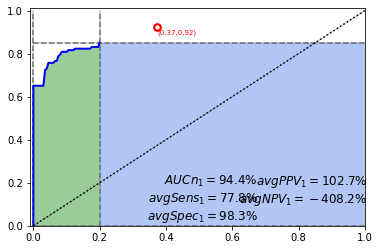

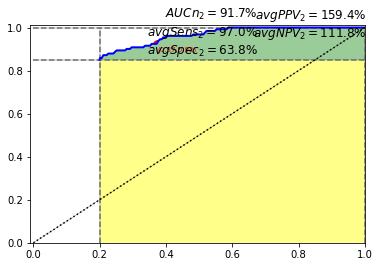

In [13]:
# @title
import matplotlib.pyplot as plt
from matplotlib.pyplot import grid, figure
from deeproc.Helpers.ROCFunctions import optimal_ROC_point_indices
from deeproc.Helpers.ROCFunctions import getSlopeOrSkew
from deeproc.Helpers.ROCPlot      import plotOptimalPoint

# Deep ROC plots, one per group
print('Plots in deep ROC analysis (Carrington et al, 2022) show performance in')
print('subgroups. AUC in part of an ROC curve, is the concordant partial AUC,')
print('normalized (AUCn_i). It is an area-weighted average of average sensitivity')
print('(vertical) and average specificity (horizontal).\n')

print('Legend: \n   vertical area: yellow (and green for overlap)')
print('   horizontal area: blue (and green for overlap)\n')

print('Note: average sensitivity and average specificity are based on areas')
print('(area integrals, not line integrals). So, e.g., if the horizontal area')
print('is zero, then the corresponding measure or part of a measure is zero.\n')

whichMeasures  = []

##    Annotate plot with pre-test measures...

## AUC in part of a ROC curve: concordant partial AUC
# whichMeasures += ['AUC_i']  # 0.5*(vert+horiz area), sum=AUC
whichMeasures   += ['AUCn_i'] # normalized for comparisons to AUC,
                              # to other parts re AUCn_i, or to other 
                              # normalized measures, e.g. avgSens

## C in part of a ROC curve: partial C statistic
# whichMeasures += ['C_i']  # 0.5*(vert+horiz "placement values"), sum=C
# whichMeasures += ['Cn_i'] # normalized for comparisons to C, AUC, etc

## Sensitivity in part of a ROC curve: partial AUC
# whichMeasures += ['pAUC']   # vertical area; sum=AUC
# whichMeasures += ['pAUCn']  # =avgSens, normalized for comparisons
# print('Note: pAUC normalized is average sensitivity.')
whichMeasures += ['avgSens']  # discrete computation, =pAUCn

## Specificity in part of a ROC curve: horizontal partial AUC
# whichMeasures += ['pAUCx']  # horizontal area; sum=AUC
# whichMeasures += ['pAUCxn'] # =avgSpec, normalized for comparisons
# print('Note: pAUCx normalized is average specificity.')
whichMeasures += ['avgSpec']  # discrete computation, =pAUCxn

##    Annotate plot with post-test measures...

whichMeasures += ['avgPPV'] # avg positive predictive value, precision
whichMeasures += ['avgNPV'] # avg negative predictive value, inverse precision
# whichMeasures += ['avgLRp'] # avg likelihood ratio positive
# whichMeasures += ['avgLRn'] # avg likelihood ratio negative
# whichMeasures += ['avgOR']  # avg odds ratio

##    Annotate plot with additional pre-test measures...

# whichMeasures += ['Uy_count']   # vertical part of U statistic
# whichMeasures += ['C_area_y']   # vertical "placement value", sum=C
# whichMeasures += ['Cn_avgSens'] # normalized for comparisons

# whichMeasures += ['Ux_count']   # horizontal part of U statistic
# whichMeasures += ['C_area_x']   # horizontal "placement value", sum=C
# whichMeasures += ['Cn_avgSpec'] # normalized for comparisons

## Specificity in part of a ROC curve FPR=[x,1]: partial area index
if groupAxis == 'FPR':
  print('', end='')  # do nothing
  # whichMeasures += ['PAI']  
  # print('Note: We compute a proxy measure for PAI.')

## Erroneous attempt at AUC in a part: standardized partial area
if groupAxis == 'FPR':
  print('', end='')  # do nothing
  # whichMeasures += ['sPA']
  # print('Note: We compute a proxy measure for sPA.')

print('Plot annotations can be changed in the code.')
print(f'Annotating with: {whichMeasures}\n')
print(f'See comments in code for a detailed description of measures.\n')

numgroups = len(groups)
for i in range(0, numgroups):
  if   rocChoice == 1:
    aDeepROC.plotGroup(plotTitle=f'Deep ROC Plot for group {i+1}', 
                        groupIndex=i, showError=False, showThresholds=True, 
                        showOptimalROCpoints=True, costs=costs, 
                        saveFileName=None, numShowThresh=20, showPlot=False, 
                        labelThresh=True, full_fpr_tpr=True)
  elif rocChoice == 2:
    aDeepROC.plotGroupForFolds(plotTitle=f'Deep ROC Plot for group {i+1}', 
                        groupIndex=i, foldsNPclassRatio=foldsNPclassRatio, 
                        showError=False, showThresholds=False, 
                        showOptimalROCpoints=True, costs=costs, 
                        saveFileName=None, numShowThresh=20, showPlot=False,
                        labelThresh=False, full_fpr_tpr=True)
    # figure(0)  # need to specify figure and subplot here
    slopeOrSkew = getSlopeOrSkew(N / P, costs)
    mean_fpr = aDeepROC.mean_fpr
    mean_tpr = aDeepROC.mean_tpr
    opt_indices = optimal_ROC_point_indices(mean_fpr, mean_tpr, slopeOrSkew)
    plotOptimalPoint(mean_fpr[opt_indices], mean_tpr[opt_indices])
    
  elif rocChoice == 3:
    aDeepROC.plotGroup(plotTitle=f'Deep ROC Plot for group {i+1}', 
                        groupIndex=i, showError=False, showThresholds=False, 
                        showOptimalROCpoints=True, costs=costs, 
                        saveFileName=None, numShowThresh=20, showPlot=False, 
                        labelThresh=False, full_fpr_tpr=True)
  #endif

  top = False   # annotate on the bottom
  if   aDeepROC.groupAxis == 'FPR' and measure_dict[i]['avgSens'] < 0.5:
    top = True  # annotate on the top, if area is bottom-half
  elif aDeepROC.groupAxis == 'TPR' and measure_dict[i]['avgSpec'] < 0.5:
    top = True  
  if aDeepROC.groupAxis == 'FPR' or aDeepROC.groupAxis == 'TPR':
    aDeepROC.annotateGroup(i, measure_dict, whichMeasures, top=top)
  #endif
  plt.show()
#endfor

# Deep ROC analysis numbers

In [14]:
#@title
# Deep ROC analsis per group
print('Deep ROC analysis (Carrington et al, 2022) shows performance in subgroups.')
print('AUC in part of an ROC curve, is the concordant partial AUC, normalized')
print('(AUCn_i). It is an area-weighted average of average sensitivity (vertical)')
print('and average specificity (horizontal).\n')

print('Note: average sensitivity and average specificity are based on areas')
print('(area integrals, not line integrals). So, e.g., if the horizontal area')
print('is zero, then the corresponding measure or part of a measure is zero.\n')

print('More measures can be selected in the code with verbose=True.\n')

analysisOutput.seek(0)
print(analysisOutput.read())

Deep ROC analysis (Carrington et al, 2022) shows performance in subgroups.
AUC in part of an ROC curve, is the concordant partial AUC, normalized
(AUCn_i). It is an area-weighted average of average sensitivity (vertical)
and average specificity (horizontal).

Note: average sensitivity and average specificity are based on areas
(area integrals, not line integrals). So, e.g., if the horizontal area
is zero, then the corresponding measure or part of a measure is zero.

More measures can be selected in the code with verbose=True.


Group 1:
FPR              = [0.000 0.200]
TPR              = [0.000 0.850]
Thresholds       = [1.000 1.000]

AUC_1            = 0.4954  (Concordant Partial AUC)
AUCn_1           = 0.9440  (Normalized concordant partial AUC)
 
pAUCn_1          = 0.7776  (Average sensitivity)
pAUCxn_1         = 0.9830  (Average specificity)
avgSens_1        = 0.7776  computed with discrete method
avgSpec_1        = 0.9830  computed with discrete method
 
avgPPV_1         = 1.0269 

# Concordance matrix



In [15]:
#@title

from deeproc.ConcordanceMatrixPlot import ConcordanceMatrixPlot
print('ConcordanceMatrix imported.')

# show enhanced ROC plot
if   rocChoice == 1:
  print('The concordance matrix (Carrington, 2020) shows the relationship of instances to the ROC plot.')
  print('It applies to a set or fold of empirical score/label data.')
  aCMplot = ConcordanceMatrixPlot(aDeepROC)
  aCMplot.plot(plotTitle=f'Concordance Matrix',
               showThresholds=True, showOptimalROCpoints=True, costs=costs,
               saveFileName=None, numShowThresholds=20, 
               showPlot=True, labelThresh=True)
elif rocChoice == 2:
  print('The concordance matrix (Carrington, 2020) applies to a set or fold of empirical')
  print('score/label data, not a mean ROC curve/plot.')
elif rocChoice == 3:
  print('A concordance matrix is not available for ROC input data in (fpr, tpr) form. Scores and labels are required.')


ConcordanceMatrix imported.
The concordance matrix (Carrington, 2020) applies to a set or fold of empirical
score/label data, not a mean ROC curve/plot.


# Enhancements in our ROC plots

Thresholds do not apply to a mean ROC plot (hence none are shown).
The only enhancement in this case, is the optimal ROC point (in red).


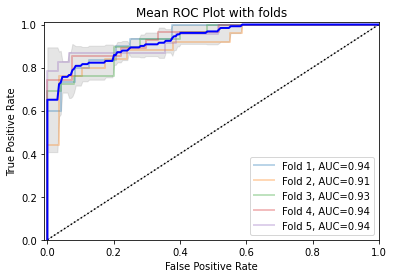

In [22]:
#@title
# Enhancements in our ROC plots with optimal ROC points and thresholds

# show enhanced ROC plot
from matplotlib.pyplot import grid, figure
if   rocChoice == 1:
  print('Enhancements include:')
  print('  - showing thresholds in the plot')
  print('  - including thresholds that are ties in score along sloped segments')
  print('  - one or more optimal ROC point(s) (red)')
  print("  - the accurate threshold at (0, 0), versus sklearn's arbitrary max(t)+1")
  fig, ax = aDeepROC.plot(plotTitle='Enhanced ROC Plot',
                showThresholds=True, showOptimalROCpoints=True, costs=costs,
                saveFileName=None, numShowThresh=20, 
                showPlot=True, labelThresh=True, full_fpr_tpr=True)
  figure(fig.number)
elif rocChoice == 2:
  # show mean ROC plot
  print('Thresholds do not apply to a mean ROC plot (hence none are shown).')
  print('The only enhancement in this case, is the optimal ROC point (in red).')

  #%matplotlib agg
  #%matplotlib agg

  # the following is a work-around until the mean ROC plot without groups
  # is fixed to show the optimal ROC point.
  fig, ax = aDeepROC.plot_folds(plotTitle='Mean ROC Plot with folds', 
                      showOptimalROCpoints=True, costs=costs,
                      saveFileName=None, showPlot=True)
  #figure(fig.number)
  #groups_temp = [[0, 1], [0, 1]]
  #aDeepROC.setGroupsBy(groupAxis=groupAxis, groups=groups_temp, 
  #                     groupByClosestInstance=False)
  #fig, ax = aDeepROC.plotGroupForFolds(plotTitle=f'Enhanced ROC Plot', 
  #                       groupIndex=0, foldsNPclassRatio=foldsNPclassRatio, 
  #                       showError=False, showThresholds=False, 
  #                       showOptimalROCpoints=True, costs=costs, 
  #                       saveFileName=None, numShowThresh=20, 
  #                      showPlot=False, labelThresh=False, full_fpr_tpr=True)
  #grid(True)
  #%matplotlib inline
  #%matplotlib inline
  plt.show()
elif rocChoice == 3:
  print('Enhancements include:')
  print('  - showing thresholds in the plot')
  print('  - including thresholds that are ties in score along sloped segments')
  print('  - one or more optimal ROC point(s) (red)')
  print("  - the accurate threshold at (0, 0), versus sklearn's arbitrary max(t)+1")
  aDeepROC.plot(plotTitle='Enhanced ROC Plot',
                showThresholds=False, showOptimalROCpoints=True, costs=costs,
                saveFileName=None, numShowThresh=20, 
                showPlot=True, labelThresh=False, full_fpr_tpr=True)
  grid(True)
#endif

# Standard ROC plot

The AUC and C statistic are equal in value for empirical ROC curves,
as continuous and discrete formulas, respectively. AUC can be computed on
fitted ROC curves and mean ROC curves, for which C is unavailable.

AUC or C statistic in each fold: 0.9375 0.9076 0.9283 0.9410 0.9411 
AUC of Mean ROC: 0.9313
Mean AUC with CIs: 0.9311 [0.9058, 0.9564]


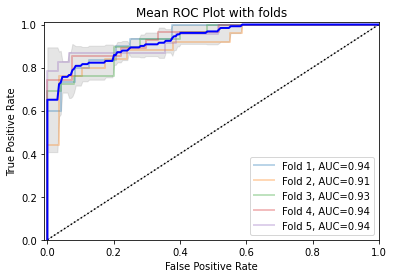

In [23]:
#@title
# Standard AUC, C statistic and ROC plot

# show AUC and C statistic
print('The AUC and C statistic are equal in value for empirical ROC curves,') 
print('as continuous and discrete formulas, respectively. AUC can be computed on') 
print('fitted ROC curves and mean ROC curves, for which C is unavailable.\n')
if   rocChoice == 1:
  print(f'AUC: {aDeepROC.getAUC():0.4f}')
  print(f'C statistic: {aDeepROC.getC():0.4f}') 
elif rocChoice == 2:
  meanAUC, lowAUC, highAUC, AUCs = aDeepROC.getMeanAUC_andCI()
  print(f'AUC or C statistic in each fold: ', end='')
  for tempAUC in AUCs:
    print(f'{tempAUC:0.4f} ', end='')
  print('')
  print(f'AUC of Mean ROC: {aDeepROC.getAUCofMeanROC():0.4f}')
  print(f'Mean AUC with CIs: {meanAUC:0.4f} [{lowAUC:0.4f}, {highAUC:0.4f}]')
elif rocChoice == 3:
  print(f'AUC: {aDeepROC.getAUC():0.4f}')
#endif

# show standard ROC plot
from sklearn.metrics         import roc_curve
from matplotlib.pyplot       import figure, plot, title, show, grid
from deeproc.Helpers.ROCPlot import plotROC
if   rocChoice == 1:
  fpr, tpr, threshold = roc_curve(labels, scores, drop_intermediate=False)
  plotROC(fpr, tpr, 'ROC plot', numThresh=1, thresh=[0], fancyLabel=None)
  grid(True)
  #figure()
  #plot(fpr, tpr)
  #title('ROC plot')
elif rocChoice == 2:
  # show mean ROC plot
  aDeepROC.plot_folds(plotTitle='Mean ROC Plot with folds')
elif rocChoice == 3:
  plotROC(fpr, tpr, 'ROC plot', numThresh=1, thresh=[0], fancyLabel=None)
  grid(True)
  #figure()
  #plot(fpr, tpr)
  #title('ROC plot')
#endif